<a href="https://colab.research.google.com/github/Ahomagai/MIMICIII_frequent_user_pred/blob/main/BaggingClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Bagging Classifier time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
from google.colab import files


uploaded = files.upload()

Saving mimic_v6_labelled.csv to mimic_v6_labelled.csv


In [3]:
#import libraries and data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [4]:
df = pd.read_csv("/content/mimic_v6_labelled.csv")

print(df.shape)

(26176, 28)


In [5]:
# Identify and replace erroneous temp values
# Sort the DataFrame by subject_id and any other relevant column (e.g., timestamp)
df.sort_values(by=['subject_id', 'admittime'], inplace=True)

# Create a function to replace the values of 6 with the last value above 30
def replace_values(group):
    last_above_30 = None
    new_temp = []

    for temp in group['temp']:
        if temp > 30:
            last_above_30 = temp
        elif last_above_30 is None:
            last_above_30 = 36.66667  # Default value if no values above 30
        new_temp.append(last_above_30 if temp in (4, 5, 6) else temp)

    group['temp'] = new_temp
    return group


# Apply the function to each group of unique participants
df = df.groupby('subject_id').apply(replace_values)

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

<ipython-input-5-63ef52bf1172>:22: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('subject_id').apply(replace_values)


In [6]:
# clean df, remove unrequired features and setup categorical and numerical df
df['Medication_count'] = df['unique_cv_items_count'] + df['unique_mv_items_count']


bin_edges = [0, 1, 2, 3, 4, float('inf')]
bin_labels = ['1', '2', '3', '4', '>4']

# Apply binning to the 'num_unique_icd9_codes' column
df['num_unique_icd9_codes_bin'] = pd.cut(df['num_unique_icd9_codes'], bins=bin_edges, labels=bin_labels)

# Apply binning to the 'Medication_count' column
df['Medication_count_bin'] = pd.cut(df['Medication_count'], bins=bin_edges, labels=bin_labels)

df = df.drop(columns=['Unnamed: 0.1','Unnamed: 0','subject_id','admittime',
                      'deathtime','marital_status',
                      'hadm_id', 'icd9_code_2','icd9_code_3',
                      'dischtime','admission_type',
                      'unique_cv_items_count','unique_mv_items_count',
                      'num_unique_icd9_codes','Medication_count','diagnosis'])

df= df.dropna()

In [7]:
# replace Age > 300
def replace_above_300(value):
    if value > 300:
        return value - 210
    return value

# Apply the function to the 'age' column
df['age'] = df['age'].apply(replace_above_300)

In [8]:
df.describe()

,age,los,icd9_code_1,hr,nbp,spo2,rr,temp,Label
count,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000
mean,63.304587,10.967243,4879.559690,88.512580,87.774858,97.259015,18.516545,33.622603,0.121391
std,17.304137,10.737337,3103.902339,20.586571,832.051419,4.633746,6.203092,10.019697,0.326588
min,18.022083,-0.116667,11.000000,0.000000,0.000000,0.000000,0.000000,0.777778,0.000000
25%,51.942804,4.739583,3601.000000,75.000000,69.000000,96.000000,14.000000,36.444401,0.000000
50%,64.843536,7.865972,3951.000000,87.000000,80.000000,98.000000,18.000000,36.666670,0.000000
75%,77.225612,13.505556,8102.000000,100.000000,92.333298,100.000000,22.000000,36.666670,0.000000
max,100.280859,202.762500,9978.000000,941.000000,120130.030000,100.000000,160.000000,40.833302,1.000000


In [9]:
df.keys()

Index(['age', 'gender', 'los', 'discharge_location', 'insurance', 'ethnicity',
       'icd9_code_1', 'hr', 'nbp', 'spo2', 'rr', 'temp', 'Label',
       'num_unique_icd9_codes_bin', 'Medication_count_bin'],
      dtype='object')

In [10]:
categ_columns = ['gender','discharge_location','insurance','ethnicity',
                      'icd9_code_1','num_unique_icd9_codes_bin','Medication_count_bin']

from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for column in categ_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  label_encoders[column] = label_encoder


In [11]:
# split into X and y
y_df = df['Label']
y_df.columns = ['Label']

In [12]:
# Split X numerical and Categorical
x_df = df.copy()

#x_df_cat = x_df[['gender','discharge_location','insurance','ethnicity',
               # 'icd9_code_1','num_unique_icd9_codes_bin','Medication_count_bin']].copy()

x_df_cat = pd.get_dummies(df[['discharge_location','insurance','ethnicity','icd9_code_1','gender', 'Medication_count_bin', 'num_unique_icd9_codes_bin']])

x_df_num = x_df.drop(['gender','discharge_location','insurance','ethnicity',
                      'icd9_code_1','Label','num_unique_icd9_codes_bin','Medication_count_bin'], axis = 1).astype('float64')
x_df_num

,age,los,hr,nbp,spo2,rr,temp
0,76.526788,10.784722,95.0,36.666698,98.0,16.0,36.055599
1,47.845044,7.759028,111.0,80.666702,98.0,18.0,37.444401
2,50.148292,25.529167,90.0,64.000000,96.0,19.0,37.222198
3,39.866116,6.855556,80.0,71.333298,98.0,19.0,37.277802
5,50.841554,2.206250,95.0,113.667000,100.0,27.0,37.666698
...,...,...,...,...,...,...,...
26171,65.262831,6.814583,71.0,66.000000,95.0,18.0,36.666670
26172,65.377831,6.128472,94.0,71.000000,99.0,21.0,36.666670
26173,78.576622,3.079861,69.0,82.000000,98.0,21.0,36.666670
26174,53.808478,16.595833,118.0,102.000000,84.0,33.0,36.666670


In [13]:
# numerical is under x_df_num
X_numerical = x_df_num

In [14]:
print(len(x_df), len(y_df), len(x_df_num))

20883 20883 20883


In [15]:
list_numerical = X_numerical.columns
list_numerical

Index(['age', 'los', 'hr', 'nbp', 'spo2', 'rr', 'temp'], dtype='object')

In [16]:
for key in x_df_cat.keys():
    print('CATEGORICAL KEYS', key)

for key in x_df_num.keys():
    print('\n','NUMERIC KEYS',key)

CATEGORICAL KEYS discharge_location
CATEGORICAL KEYS insurance
CATEGORICAL KEYS ethnicity
CATEGORICAL KEYS icd9_code_1
CATEGORICAL KEYS gender
CATEGORICAL KEYS Medication_count_bin
CATEGORICAL KEYS num_unique_icd9_codes_bin

 NUMERIC KEYS age

 NUMERIC KEYS los

 NUMERIC KEYS hr

 NUMERIC KEYS nbp

 NUMERIC KEYS spo2

 NUMERIC KEYS rr

 NUMERIC KEYS temp


In [17]:
# Scale numerical features
scaled_x_df_num = pd.DataFrame(StandardScaler().fit_transform(x_df_num), columns = x_df_num.keys())

In [18]:
scaled_x_df_num.describe()

,age,los,hr,nbp,spo2,rr,temp
count,2.088300e+04,2.088300e+04,2.088300e+04,2.088300e+04,2.088300e+04,2.088300e+04,2.088300e+04
mean,-5.335110e-16,-1.224898e-16,-1.742077e-16,-1.360997e-18,2.653945e-17,-2.041496e-16,6.532788e-16
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,-2.616923e+00,-1.032302e+00,-4.299633e+00,-1.054946e-01,-2.098979e+01,-2.985122e+00,-3.278104e+00
25%,-6.566092e-01,-5.800142e-01,-6.563941e-01,-2.256508e-02,-2.717121e-01,-7.281292e-01,2.816318e-01
50%,8.893741e-02,-2.888374e-01,-7.347585e-02,-9.344428e-03,1.599145e-01,-8.327410e-02,3.038155e-01
75%,8.045104e-01,2.364062e-01,5.580189e-01,5.478686e-03,5.915411e-01,5.615810e-01,3.038155e-01
max,2.136897e+00,1.786289e+01,4.141087e+01,1.442761e+02,5.915411e-01,2.280908e+01,7.196695e-01


In [19]:
# Find outliers based on 1.5*(Q3-Q1) outlier step
outliers  = []
# For each feature find the data points with extreme high or low values
for feature in scaled_x_df_num.keys():
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(scaled_x_df_num[feature],25)
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(scaled_x_df_num[feature],75)
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    outliers_per_feature = scaled_x_df_num[~((scaled_x_df_num[feature] >= Q1 - step) & (scaled_x_df_num[feature] <= Q3 + step))]
    outliers = outliers + list(outliers_per_feature.index)
outliers.sort()
outliers = list(set(outliers))

# Remove outliers
clean_scaled_x_df_num = scaled_x_df_num.drop(scaled_x_df_num.index[outliers]).reset_index(drop = True)
print('{} outliers removed'.format(len(outliers)))

8816 outliers removed


In [20]:
# Convert categorical features to "One Hot Encoding" vectors and drop outliers
clean_x_df_cat = x_df_cat.drop(x_df_cat.index[outliers]).reset_index(drop = True)
# clean_x_df_cat_ohe = pd.get_dummies(clean_x_df_cat, drop_first=True)
# dummies = pd.get_dummies(clean_x_df_cat)

In [21]:
# Recombine scaled numerical and encoded categorical features by concatination
x_df = pd.concat([clean_scaled_x_df_num, clean_x_df_cat], axis = 1)
# x_df = pd.concat([clean_scaled_x_df_num, dummies], axis = 1)

In [22]:
# Drop outliers from label Dataframe as well
y_df = y_df.drop(y_df.index[outliers]).reset_index(drop = True)

In [23]:
print(len(y_df), len(x_df))

12067 12067


In [24]:
y_df.columns = ['Label']

In [25]:
print(y_df.value_counts())
print('\nPositive label proportion: ')
print(y_df.value_counts()/y_df.shape[0])

0    10658
1     1409
Name: Label, dtype: int64

Positive label proportion: 
0    0.883235
1    0.116765
Name: Label, dtype: float64


In [26]:
# write final files to local dir
x_df.to_csv('/content/x_df.csv')
y_df.to_csv('/content/y_df.csv')

In [ ]:
# Bagging Classifier time

In [33]:
# Import data
y = pd.read_csv('/content/y_df.csv')
X = pd.read_csv('/content/x_df.csv')

In [34]:
# split into test & train
test_size = 0.10
seed= 7
X = X.drop(columns = ['Unnamed: 0'])
y = y.drop(columns = ['Unnamed: 0'])

print(X.keys())
print(y.keys())


Index(['age', 'los', 'hr', 'nbp', 'spo2', 'rr', 'temp', 'discharge_location',
       'insurance', 'ethnicity', 'icd9_code_1', 'gender',
       'Medication_count_bin', 'num_unique_icd9_codes_bin'],
      dtype='object')
Index(['Label'], dtype='object')


In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [36]:
# balance training sets
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_train,y_train = resample.fit_resample(X_train,y_train)

In [37]:
# bagging classifier, but used properly
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix

model = BaggingClassifier(tree.DecisionTreeClassifier(random_state = 1))
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8773819386909694


Bagging Classifier Accuracy: 0.8773819386909694


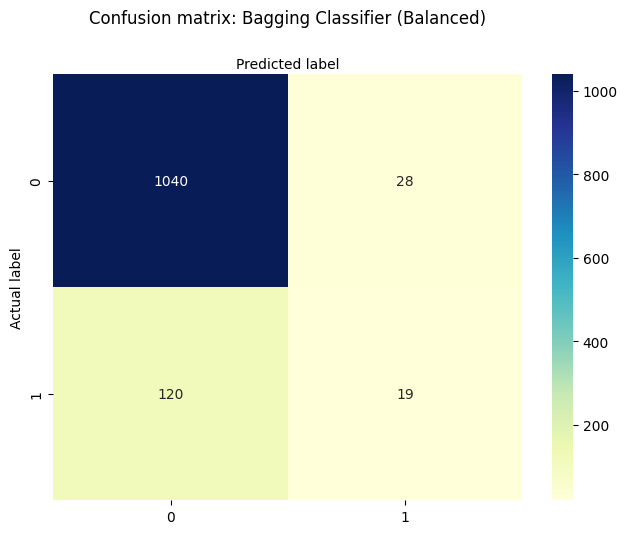

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred2 = model.predict(X_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred2)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix: Bagging Classifier (Balanced)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Bagging Classifier Accuracy:",metrics.accuracy_score(y_test, y_pred2))

# bagging classifier, with actual proper balancing results in an accuracy of 80.9%

In [40]:
from sklearn.metrics import precision_score, f1_score

In [41]:
y_true=y_test
y_pred=y_pred2

precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("F1 Score: ", f1)

Precision: 0.40425531914893614
F1 Score:  0.20430107526881722
